# Plaque Barcoding pipeline
Follow along our analysis steps and reproduce our results with the scripts below.  

**Dependencies**
* epicBarcoder (custom library on github)
* pandas
* pear
* usearch v9.2
* sina v1.2.11
* fasttree  

## Initialization

In [2]:
import os
import sys
import subprocess
import epicBarcoder as eb
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
#Set up personal computing environment with paths to necessary tools and data directories
env = os.environ
dataDir = '/home/ubuntu/users/sjspence/170214_OM8/04_jupyter/'
pearPath = '/usr/local/bin/pear'
usearchPath = '/home/ubuntu/users/sjspence/tools/usearch9.2.64_i86linux32'
sinaPath = '/home/ubuntu/bin/sina-1.2.11/sina'
fasttreePath = '/home/ubuntu/bin/FastTree_dd'

In [4]:
#Import and edit mapping file
sampIDs = []
mapping = {}
readCounts = {}
with open(dataDir + 'OM8_map.txt', 'r') as inFile:
    for line in inFile:
        if '#' not in line:
            line = line.strip().split('\t')
            mapping[line[1]] = line[0].replace('_','s')
            readCounts[line[1]] = 0
            sampIDs.append(line[0].replace('_','s'))
inFile.close()

## Pre-processing

In [ ]:
#Join paired-end reads
subprocess.call([pearPath, '-f', dataDir + '170214Alm_D17-2046_1_sequence.fastq', 
                 '-r', dataDir + '170214Alm_D17-2046_2_sequence.fastq', '-o', dataDir + '01_pear'])

In [16]:
#Break up file into pieces that usearch can use (5 million lines each)
#Run this to completion before running next section
inFile = open(dataDir + '01_pear.assembled.fastq', 'r')
if not os.path.exists(dataDir + '02_pearSplits/'):
    os.makedirs(dataDir + '02_pearSplits/')
i = 0
j = 1
partFile = open(dataDir + '02_pearSplits/pear_' + str(j) + '.fastq', 'w')
for line in inFile:
    if i >= j*5000000:
        partFile.close()
        j += 1
        partFile = open(dataDir + '02_pearSplits/pear_' + str(j) + '.fastq', 'w')
    partFile.write(line)
    i += 1
partFile.close()
inFile.close()
print(i)

71812424


In [23]:
#Quality filter with usearch 9 max-error rate
def qualFilter(inFile, outFile):
    subprocess.call([usearchPath, "-fastq_filter", inFile, "-fastq_minlen", '100', '-fastq_maxee_rate', '0.01',
                     "-fastqout", outFile], env=env)
for filename in os.listdir(dataDir + '02_pearSplits/'):
    qualFilter(dataDir + '02_pearSplits/' + filename, dataDir + '02_pearSplits/' + filename.replace('.fastq','filt.fastq'))

In [25]:
#Join quality-filtered files back into a single file for processing
with open(dataDir + '02_pear_filt.fastq', 'w') as outfile:
    for fname in os.listdir(dataDir + '02_pearSplits/'):
        if 'filt' in fname:
            with open(dataDir + '02_pearSplits/' + fname, 'r') as infile:
                for line in infile:
                    outfile.write(line)
            infile.close()
outfile.close()

In [38]:
#Demultiplex: check for barcodes and relabel sequences
#Use mapping file to keep barcoded sequences, prepare fasta file
with open(dataDir + '02_pear_filt.fastq', 'r') as inFile:
    with open(dataDir + '03_pear_filt.fasta', 'w') as outFile:
        i = 0
        j = 0
        nextSeq = False
        for line in inFile:
            if nextSeq:
                outFile.write(line)
                nextSeq = False
            if i%4 == 0:
                for bc in mapping:
                    if bc in line:
                        readCounts[bc] += 1
                        newLine = line.strip().replace('@','>' + mapping[bc] + '_' + str(j) + ' ')
                        newLine = newLine + ' orig_bc=' + bc + ' new_bc=' + bc + ' bc_diffs=0\n'
                        outFile.write(newLine)
                        nextSeq = True
                        j += 1
            i += 1
inFile.close()
outFile.close()
#Summarize read mapping after quality filtering and zero-error barcode matching
total = 0
summaryFile = open(dataDir + '03_quality_summary.txt', 'w')
for s in sampIDs:
    for bc in mapping:
        if mapping[bc] == s:
            summaryFile.write(s + '\t' + str(readCounts[bc]) + '\n')
            total += readCounts[bc]
summaryFile.write('Total\t' + str(total))
summaryFile.close()

In [3]:
#Primer check and removal, placing droplet barcode into header
#NOTE: this takes a while
qualReads = eb.importFasta(dataDir + '03_pear_filt.fasta')
noPrimerReads = eb.filtBarcodePrimers(qualReads, 20, 'GATCATGACCCATTTGGAGAAGATG', 'GGACTACHVGGGTWTCTAAT')
eb.exportFasta(noPrimerReads, dataDir + '04_pear_noPrimers.fasta')
print(len(qualReads))
print(len(noPrimerReads))
print(noPrimerReads[0].header)
print(noPrimerReads[0].seq)

## Dereplication and denoising

In [3]:
#Collapse identical reads and maintain the provenance to reduce the uclust file size
#uniqueDict maps a unique sequence to a list of read objects which contain it
#NOTE: takes a long time, but rerun after notebook closes out
#OUTPUT: uniqueDict is a dictionary mapping a unique sequence to a list of read objects which contain it
uniqueDict = eb.getUniqueSeqs(dataDir + '04_pear_noPrimers.fasta', dataDir + '05_unique_seqs.fasta')

In [3]:
#Use the usearch unoise algorithm to create zero radius OTUs (zOTUs), while also discarding chimeras, phiX sequences,
#and low complexity DNA
#Input: unique sequences collapsed from quality- and primer- filtered data
#Output: Denoised file with true biological reads
#        Database file with true amplicon reads including chimeras
subprocess.call([usearchPath, '-unoise2', dataDir + '05_unique_seqs.fasta', '-fastaout', dataDir + '06_denoised.fa',
                 '-otudbout', dataDir + '06_db.fa', '-minampsize', '3'], env=env)

0

**Unoise output**  
00:02 332Mb   100.0% Reading 05_unique_seqs.fasta  
00:04 352Mb   100.0% 3955 amplicons, 1791728 bad (size >= 3)
01:55 359Mb   100.0% 354 good, 3601 chimeras

46735 corrected amplicon sequences (including chimeras) in 06_db.fa  
354 output biological sequences in 06_denoised.fa

In [ ]:
#Combine taxonomic information to export final file with droplet barcodes
#Added an if statement, since this variable technically gets created earlier in the pipeline
if 'uniqueDict' not in globals():
    uniqueDict = eb.getUniqueSeqs(dataDir + '04_pear_noPrimers.fasta', dataDir + '05_unique_seqs.fasta')

#Take denoised zOTUs, then map back to original reads and rewrite original read file (minus noisy reads) with
#zOTU and information in the headers
eb.expandDenoised(uniqueDict, dataDir + '06_denoised.fa', dataDir + '08_denoised_all_seqs.fa')

**Read loss from unoise2**

24490106 04_pear_noPrimers.fasta = 12,245,053 reads prior to unoise2  
18228922 08_all_seqs_tax.fa = 9,114,461 reads after unoise2  

Approximately 25% read loss.

## Taxonomic assignment

In [7]:
#NOTE: ONLY NEED TO RUN THIS ONCE

#Format fasta database for input to SINTAX
#Maintained HOMD HOT strain ID in header following the taxonomic information
#Example SINTAX header structure below:
#>AB008314;tax=d:Bacteria,p:Firmicutes,c:Bacilli,o:Lactobacillales,f:Streptococcaceae,g:Streptococcus;
outFile = open(dataDir + 'HOMD_16S_rRNA_RefSeq_V14.5.p9_sintax_spike.fasta', 'w')
taxDict = {}
with open(dataDir + 'HOMD_16S_rRNA_RefSeq_V14.5.qiime_spike.taxonomy', 'r') as t:
    for line in t:
        line = line.strip().split('\t')
        taxID = line[0]
        tax = line[1].strip().replace('__',':')
        tax = tax.replace(';',',')
        taxDict[taxID] = tax
with open(dataDir + 'HOMD_16S_rRNA_RefSeq_V14.5.p9_spike.fasta', 'r') as f:
    for line in f:
        if '>' in line:
            line = line.strip().split(' ')
            taxInfo = taxDict[line[0].replace('>','')]
            outLine = line[0] + ';tax=' + taxInfo + ';'
            for i in line:
                if 'HOT' in i:
                    outLine += i + ';'
            outFile.write(outLine + '\n')
        else:
            outFile.write(line)
outFile.close()
subprocess.call([usearchPath, '-makeudb_sintax', dataDir + 'HOMD_16S_rRNA_RefSeq_V14.5.p9_sintax_spike.fasta', 
                 '-output', dataDir + 'HOMD_16S_rRNA_RefSeq_V14.5.p9_sintax_spike.udb'], env=env)

0

**Database formatting output**  
00:00 14Mb   1020 names, tax levels min 7, avg 7.0, max 7  
WARNING: 25 taxonomy nodes have >1 parent  
00:00 14Mb   Buffers (892 seqs)

In [4]:
#Run SINTAX to determine denoised read taxonomic information
#Default is to run one thread per CPU core, or 10 threads if there are > 10 cores
subprocess.call([usearchPath, '-sintax', dataDir + '06_denoised.fa', 
                 '-db', dataDir + 'HOMD_16S_rRNA_RefSeq_V14.5.p9_sintax_spike.udb', 
                 '-tabbedout', dataDir + '07_denoised.sintax', 
                 '-strand', 'plus', '-sintax_cutoff', '0.8', '-threads', '4'], env=env)

0

## Droplet barcode parsing

In [5]:
#Within each sample, group by barcode; quantify unique barcode pairings
#Input: Fasta file with droplet barcode, otu, and taxonomic information in the header
#Output: A dictionary where each sampID maps to a dictionary of droplet barcodes:[zOTU1, zOTU1, zOTU2, ...]
barcodeDict = eb.createBarcodeDict(dataDir + '08_denoised_all_seqs.fa')

#Export summary file of droplet barcodes per sample
if not os.path.exists(dataDir + '08_barcoding_log.txt'):
    eb.summarizeBarcoding(barcodeDict, sampIDs, dataDir + '08_barcoding_log.txt')

#Import sintax taxonomy as a dictionary mapping zOTU IDs to a >80% taxonomic assignment string
taxDict = eb.importSintax(dataDir + '07_denoised.sintax', 'final')
otuDf = eb.tOTUmap(taxDict)

In [6]:
#Create pandas dataframe with the relative abundances of different tOTUs calculated from singleton barcode data
abundanceDf = eb.tOTU_singletonAbundances(barcodeDict, taxDict)

#Create pandas data frame with tOTU pairs in rows (as 'tOTU1__tOTU2') and sample IDs in columns.  Data is the number
#of barcodes supporting the pair
pairDf = eb.tOTU_quantifyPairs(barcodeDict, taxDict)

In [6]:
#Identify shewanella oneidensis tOTU to feed into connection files for significance thresholding
shew_tOTU = ''
for i, tax in enumerate(otuDf['taxonomy']):
    if 'g:Shewanella,s:oneidensis' in tax:
        shew_tOTU = otuDf['tOTU'].iloc[i]
        break
print('Shewanella tOTU: ' + shew_tOTU)

Shewanella tOTU: tOtu10


## Prep iTol files

In [4]:
#Make tree for tOTUs in the complete dataset
#Choose representative sequence based on abundance in taxonomic group, export fasta of representative seqs
eb.tOTU_pickRepSeqs(dataDir + '06_denoised.fa', dataDir + '07_denoised.sintax', dataDir + '09_repSeqs.fa')

In [5]:
#Align and build tree from tOTUs
#Produce alignments with the representative OTU sequences, use the silva aligner against reference
inFile = dataDir + '09_repSeqs.fa'
outFile = inFile.replace('.fa', '_aligned.fa')
database = dataDir + 'SSURef_NR99_128_SILVA_07_09_16_opt.arb'
logFile = open(inFile.replace('.fa', '_sinaLog.txt'), 'w')
subprocess.call([sinaPath, "-i", inFile, "-o", outFile, "--intype", 'fasta', "--outtype",
                 'fasta', "--ptdb", database], stdout=logFile, env=env)

0

In [6]:
#Build the tree
inFile = dataDir + '09_repSeqs_aligned.fa'
outFile = open(inFile.replace('_aligned.fa', '.tre'), 'w')
subprocess.call([fasttreePath, '-nt', '-gtr', inFile], stdout=outFile, env=env)

0

In [7]:
#Make iTol abundance files and zip them into an output directory
eb.itolSimpleBar(abundanceDf, dataDir + '09_itol_abundances/')

In [7]:
#Make iTol total connection files
eb.itolConnections(pairDf, dataDir + '09_itol_allConnect/', 'all', '#999999')

In [19]:
#Make iTol significant connection files
posDf, negDf = eb.pickSigPairs(pairDf, abundanceDf, dataDir + '08_barcoding_log.txt', 1e-3)
eb.itolConnections(posDf, dataDir + '09_itol_pos/', 'pos', '#c14343')
eb.itolConnections(negDf, dataDir + '09_itol_neg/', 'neg', '#3e40a0')

In [15]:
#Make iTol file with taxonomic hover-over info
tOTUdict = {}
for index in list(otuDf.index.values):
    tax = otuDf['taxonomy'][index]
    tOTU = otuDf['tOTU'][index]
    tOTUdict[tOTU] = tax.replace(',','_')
tOTU_column = {'taxonomy': tOTUdict}
tOTUdf = pd.DataFrame.from_dict(tOTU_column)
eb.itolHover(tOTUdf, dataDir + '09_itol_hover.txt')

In [17]:
#Summarize shewanella significant pairing


## Additional figure generation

In [11]:
#Plot OTU-level replicates vs. singletons
scatterDict = {}
for s in barcodeDict:
    singletons = {}
    replicates = {}
    for bc in barcodeDict[s]:
        zOTUs = barcodeDict[s][bc]
        tOTUs = []
        for z in zOTUs:
            t = otuDf['tOTU'][z]
            tOTUs.append(t)
        if len(tOTUs) == 1:
            if tOTUs[0] in singletons:
                singletons[tOTUs[0]] += 1
            else:
                singletons[tOTUs[0]] = 1
        elif len(set(tOTUs)) == 1:
            if tOTUs[0] in replicates:
                replicates[tOTUs[0]] += 1
            else:
                replicates[tOTUs[0]] = 1
    scatterDict[s + '_s'] = singletons
    scatterDict[s + '_r'] = replicates
scatterDf = pd.DataFrame.from_dict(scatterDict).fillna(0)

In [12]:
#Prepare plot with all samples arrayed together
n, m = 4, 6

with PdfPages('replicate_singleton_subplots.pdf') as pdf:
    f, axarr = plt.subplots(n, m, sharex='col', sharey='row', figsize=(15,15))
    arr_ij = [(x,y) for x,y in np.ndindex(axarr.shape)]
    subplots = [axarr[index] for index in arr_ij]
    splot_index = 0
    for s in sampIDs:
        if (s not in barcodeDict) or (scatterDf[s + '_s'].sum() < 100):
            continue
        posControls = ['OM8s13', 'OM8s14', 'OM8s15', 'OM8s16', 'OM8s17', 'OM8s18']
        if s in posControls:
            continue
        subplots[splot_index].scatter(scatterDf[s + '_s'], scatterDf[s + '_r'])
        subplots[splot_index].set_title(s)
        subplots[splot_index].set_xlim
        #Set axes to start at zero
        #cur_xlim = subplots[splot_index].get_xlim()
        #cur_ylim = subplots[splot_index].get_ylim()
        #subplots[splot_index].set_xlim(0, cur_xlim[1])
        #subplots[splot_index].set_ylim(0, cur_ylim[1])
        splot_index += 1
    for ax in f.axes:
        matplotlib.pyplot.sca(ax)
        plt.xticks(rotation=45)
    f.text(0.5, 0.05, 'Singletons', ha='center')
    f.text(0.05, 0.5, 'Replicates', va='center', rotation='vertical')
    pdf.savefig()
    plt.close(f)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


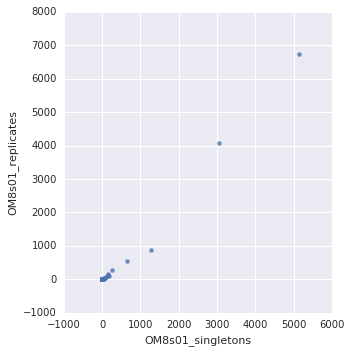

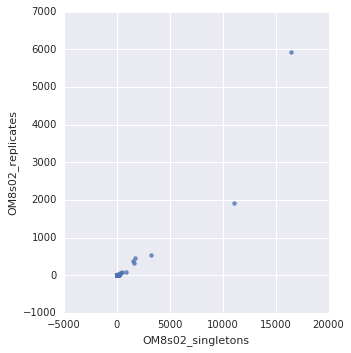

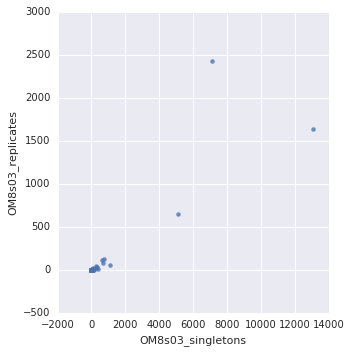

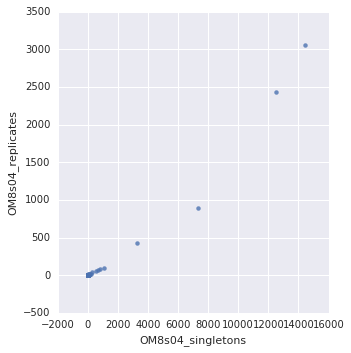

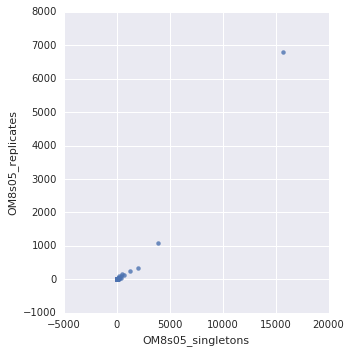

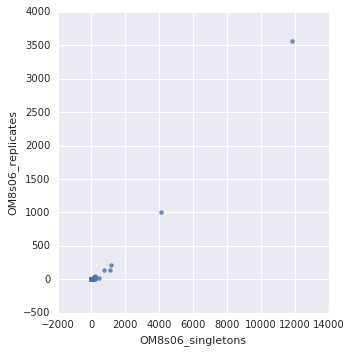

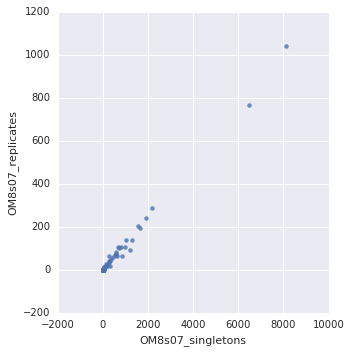

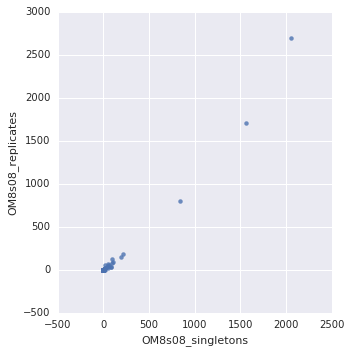

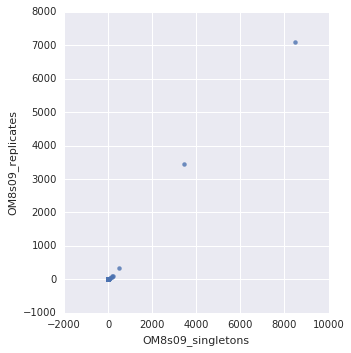

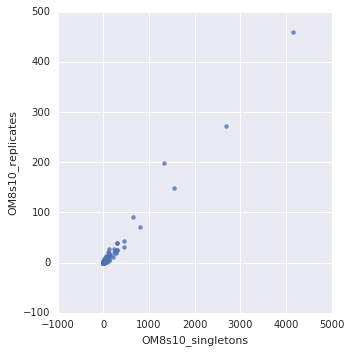

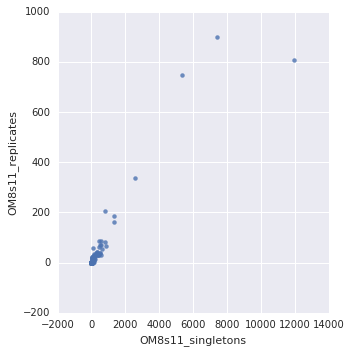

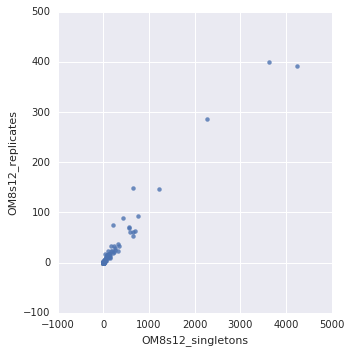

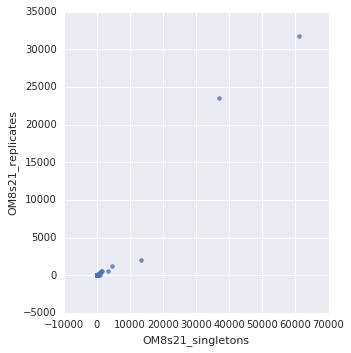

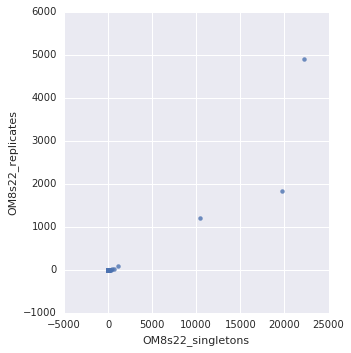

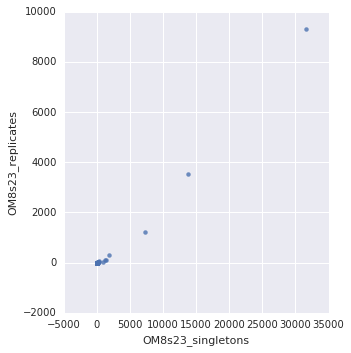

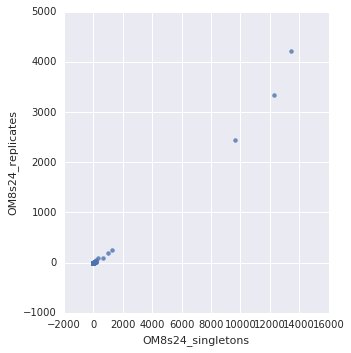

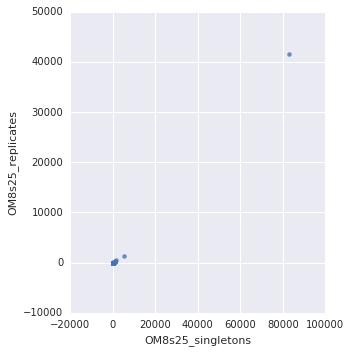

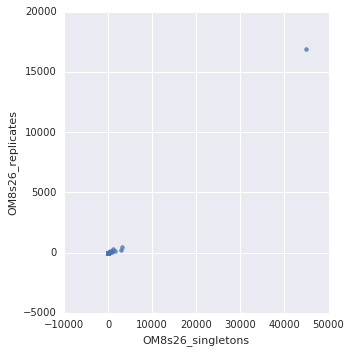

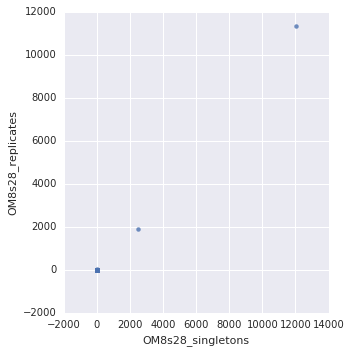

In [13]:
#Prepare plot with samples plotted individually
with PdfPages('replicate_singleton_individualPlots.pdf') as pdf_pages:
    for s in sampIDs:
        if (s not in barcodeDict) or (scatterDf[s + '_s'].sum() < 100):
            continue
        posControls = ['OM8s13', 'OM8s14', 'OM8s15', 'OM8s16', 'OM8s17', 'OM8s18']
        if s in posControls:
            continue
        current = sns.lmplot(s + '_s', s + '_r', data=scatterDf, fit_reg=False)
        current.set(xlabel=s + '_singletons', ylabel=s + '_replicates')
        pdf_pages.savefig(current.fig)

In [14]:
#Plot tOTU singletons, replicates, total, etc.
barDf = pd.DataFrame()
barIndex = ['samp', 'ct', 'type']
posControls = ['OM8s13', 'OM8s14', 'OM8s15', 'OM8s16', 'OM8s17', 'OM8s18']
i = 0
for s in barcodeDict:
    if s in posControls:
        continue
    totalCt = 0
    singleCt = 0
    repliCt = 0
    multiCt = 0
    for bc in barcodeDict[s]:
        totalCt += 1
        zOTUs = barcodeDict[s][bc]
        tOTUs = []
        for z in zOTUs:
            t = otuDf['tOTU'][z]
            tOTUs.append(t)
        if len(tOTUs) == 1:
            singleCt += 1
        elif len(set(tOTUs)) == 1:
            repliCt += 1
        elif len(set(tOTUs)) > 1:
            multiCt += 1
    if totalCt < 200:
        continue
    barDf[str(i)] = pd.Series((s, singleCt, 'singleton'), index=barIndex)
    i += 1
    barDf[str(i)] = pd.Series((s, repliCt, 'replicate'), index=barIndex)
    i += 1
    barDf[str(i)] = pd.Series((s, multiCt, 'multiplet'), index=barIndex)
    i += 1
barDf_t = barDf.transpose()

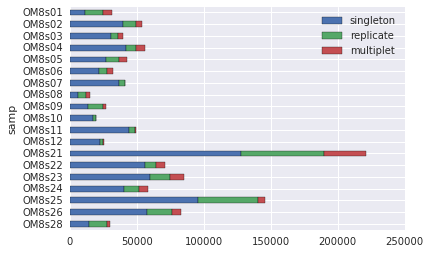

In [15]:
newBarDf = barDf_t.pivot('samp', 'type')['ct']
ax = newBarDf[newBarDf.columns[::-1]].plot(kind='barh', stacked=True)
plt.gca().invert_yaxis()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right')
plt.savefig('barcoding.pdf')

In [66]:
#Get full set of counts for computation below
ctDf = pd.DataFrame()
ctIndex = ['samp', 'ct', 'type']
i = 0
for s in barcodeDict:
    totalCt = 0
    singleCt = 0
    repliCt = 0
    multiCt = 0
    for bc in barcodeDict[s]:
        totalCt += 1
        zOTUs = barcodeDict[s][bc]
        tOTUs = []
        for z in zOTUs:
            t = otuDf['tOTU'][z]
            tOTUs.append(t)
        if len(tOTUs) == 1:
            singleCt += 1
        elif len(set(tOTUs)) == 1:
            repliCt += 1
        elif len(set(tOTUs)) > 1:
            multiCt += 1
    if totalCt < 200:
        continue
    ctDf[str(i)] = pd.Series((s, singleCt, 'singleton'), index=ctIndex)
    i += 1
    ctDf[str(i)] = pd.Series((s, repliCt, 'replicate'), index=ctIndex)
    i += 1
    ctDf[str(i)] = pd.Series((s, multiCt, 'multiplet'), index=ctIndex)
    i += 1
ctDf_t = ctDf.transpose()

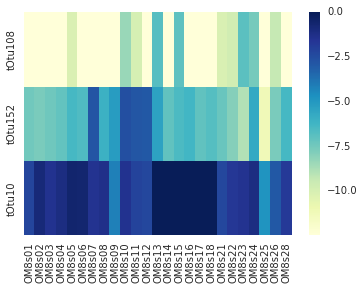

In [75]:
#Positive and negative control abundances
newCtDf = ctDf_t.pivot('samp', 'type')['ct']

for i in list(otuDf.index.values):
    if 's:coli' in otuDf['taxonomy'][i]:
        tOTU_coli = otuDf['tOTU'][i]
    if 's:subtilis' in otuDf['taxonomy'][i]:
        tOTU_sub = otuDf['tOTU'][i]
    if 's:oneidensis' in otuDf['taxonomy'][i]:
        tOTU_shew = otuDf['tOTU'][i]
controlsDf_t = pd.DataFrame()
controlsDf_t[tOTU_sub] = abundanceDf.transpose()[tOTU_sub]
controlsDf_t[tOTU_coli] = abundanceDf.transpose()[tOTU_coli]
controlsDf_t[tOTU_shew] = abundanceDf.transpose()[tOTU_shew]

maxSingletonCt = max(newCtDf['singleton'])
controlsDf = controlsDf_t.transpose().add(1.0/(2*maxSingletonCt))

remove = []
for i in controlsDf.columns.tolist():
    if i not in list(list(newCtDf.index.values)):
        remove.append(i)
        controlsDf = controlsDf.drop(i, 1)

logDf = controlsDf.apply(np.log)
sns.heatmap(logDf, vmax=0, cmap="YlGnBu")
plt.savefig('controls.pdf', bbox_inches='tight')

## Exploratory work below

In [25]:
#total pairs
#significant pairs
#shew <
#shew >

for s in posDf:
    shewPos = 0
    for i in list(posDf[s].index):
        iList = i.split('__')
        if (iList[0] == 'tOtu10') or (iList[1] == 'tOtu10'):
            if posDf[s][i] != 0:
                shewPos += 1
    print(s + '\t' + str(shewPos))

OM8s01	29
OM8s02	5
OM8s03	3
OM8s04	12
OM8s05	26
OM8s06	26
OM8s07	0
OM8s08	27
OM8s09	0
OM8s10	0
OM8s11	1
OM8s12	0
OM8s13	1
OM8s14	2
OM8s15	0
OM8s16	1
OM8s17	2
OM8s18	1
OM8s19	0
OM8s20	0
OM8s21	35
OM8s22	3
OM8s23	15
OM8s24	17
OM8s25	0
OM8s26	2
OM8s27	0
OM8s28	0
OM8s29	0
OM8s30	0
OM8s31	0
OM8s32	0
OM8s34	0


In [11]:
totals = {}
for s in barcodeDict:
    total = 0
    for bc in barcodeDict[s]:
        #If there is one unique barcode with only one sequence mapped to it
        #(true barcode singleton)
        if len(barcodeDict[s][bc]) == 1:
            total += 1
    totals[s] = total

In [28]:
from scipy.stats import poisson

#Calculate poisson probabilities that two bugs would co-occur and filter results based on that
#Print tab-delimited format showing total #pairs, #significant pairs, #shew to other, #shew to self
#Create iTol file with significant connections
cutoff = 1e-7
pairDict = pairDf.to_dict()
relAbundances = abundanceDf.to_dict()
for s in sampIDs:
    if s not in pairDict:
        continue
    i = 0
    t = 0
    shewYes = 0
    shewNo = 0
    doubleShew = 0
    for otuPair in pairDict[s]:
        if pairDict[s][otuPair] != 0.0:
            t += 1
        otu1 = otuPair.split('__')[0]
        otu2 = otuPair.split('__')[1]
        if otu1 in relAbundances[s]:
            a1 = relAbundances[s][otu1]
        else:
            a1 = 0.0
        if otu2 in relAbundances[s]:
            a2 = relAbundances[s][otu2]
        else:
            a2 = 0.0
        x = pairDict[s][otuPair]
        mu = a1 * a2 * totals[s]
        p = poisson.pmf(x, mu)
        if p < cutoff:
            i += 1
            if ('oneidensis' in tOTUdict[otu1]) and ('oneidensis' in tOTUdict[otu2]):
                doubleShew += 1
            elif ('oneidensis' in tOTUdict[otu1]) or ('oneidensis' in tOTUdict[otu2]):
                if x < mu:
                    shewYes += 1
                else:
                    shewNo += 1
    print(s + '\t' + str(t) + '\t' + str(i) + '\t' + str(shewYes) + '\t' + str(shewNo))

OM8s01	299	95	0	23
OM8s02	344	52	12	5
OM8s03	249	29	4	2
OM8s04	344	40	4	7
OM8s05	592	140	0	13
OM8s06	629	196	0	22
OM8s07	253	154	32	0
OM8s08	415	186	0	22
OM8s09	145	16	1	0
OM8s10	141	80	32	0
OM8s11	675	122	27	1
OM8s12	442	85	19	0
OM8s13	8	4	1	1
OM8s14	3	1	0	1
OM8s15	2	0	0	0
OM8s16	2	0	0	0
OM8s17	4	2	1	1
OM8s18	2	1	1	0
OM8s19	0	0	0	0
OM8s20	0	0	0	0
OM8s21	668	352	0	30
OM8s22	169	18	3	2
OM8s23	298	39	2	7
OM8s24	389	70	2	12
OM8s25	175	23	2	0
OM8s26	213	60	2	1
OM8s27	0	0	0	0
OM8s28	2	3	1	0
OM8s29	0	0	0	0
OM8s30	0	0	0	0
OM8s31	0	0	0	0
OM8s32	0	0	0	0
OM8s34	0	0	0	0


In [58]:
#What are the s. oneidensis relative abundances?
for s in sampIDs:
    if s not in relAbundances:
        continue
    print(s)
    for otu in relAbundances[s]:
        if 'oneidensis' in otu:
            print(otu + '\n' + str(relAbundances[s][otu]) + '\n')

OM8s01
k:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:Alteromonadales,f:Shewanellaceae,g:Shewanella,s:oneidensis
0.110946487711

OM8s02
k:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:Alteromonadales,f:Shewanellaceae,g:Shewanella,s:oneidensis
0.420078990954

OM8s03
k:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:Alteromonadales,f:Shewanellaceae,g:Shewanella,s:oneidensis
0.233302806306

OM8s04
k:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:Alteromonadales,f:Shewanellaceae,g:Shewanella,s:oneidensis
0.342921615202

OM8s05
k:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:Alteromonadales,f:Shewanellaceae,g:Shewanella,s:oneidensis
0.581176644822

OM8s06
k:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:Alteromonadales,f:Shewanellaceae,g:Shewanella,s:oneidensis
0.536212835388

OM8s07
k:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:Alteromonadales,f:Shewanellaceae,g:Shewanella,s:oneidensis
0.222974646957

OM8s08
k:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:Alt

In [17]:
#Try cluster_fast clustering
subprocess.call([usearchPath, '-cluster_fast', dataDir + '06_denoised.fa', '-id', '0.97', '-centroids', 
                dataDir + '09_otu_clusters.fa', '-uc', dataDir + '09_otu_clusters.uc'], env=env)

0

      Seqs  354  
  Clusters  154  
  Max size  17  
  Avg size  2.3  
  Min size  1  
Singletons  74, 20.9% of seqs, 48.1% of clusters  
   Max mem  83Mb  
      Time  1.00s  
Throughput  354.0 seqs/sec.

In [18]:
#Import list of read objects from unoise2 denoised file
denoised = eb.importFasta(dataDir + '06_denoised.fa')

#Import Otu header:[tax probabilities, taxonomy] dictionary from SINTAX output
taxDict = eb.importSintax(dataDir + '07_denoised.sintax')

#Import hits from 97% fast clustering
hits = eb.importClusterFast(dataDir + '09_otu_clusters.uc')

In [19]:
#FIRST TRY TO SEE HOW MUCH SHEWANELLA COLLAPSES BY TAXONOMY
i = 0
for t in taxDict:
    if i == 0:
        print(t)
        print(taxDict[t])
    i += 1

Otu6;uniq=OM8s21_7
['k:Bacteria(1.0000),p:Fusobacteria(1.0000),c:Fusobacteriia(1.0000),o:Fusobacteriales(1.0000),f:Fusobacteriaceae(1.0000),g:Fusobacterium(1.0000),s:nucleatum_subsp._polymorphum(0.7700)', 'k:Bacteria,p:Fusobacteria,c:Fusobacteriia,o:Fusobacteriales,f:Fusobacteriaceae,g:Fusobacterium']


In [20]:
#Check number of shewanella seqs in 97% otu clusters
i = 0
j = 0
shewSeqs = []
for h in hits:
    if j == 0:
        print(h)
    j += 1
    seqID = h.split(' ')[0]
    if 'oneidensis' in taxDict[seqID][1]:
        i += 1
print(i)

Otu111;uniq=OM8s08_7689 HWI-M04407:1:2105:24185:5342#TCTGTATG/1 orig_bc=TCTGTATG new_bc=TCTGTATG bc_diffs=0 droplet_bc=TTTGCCTTGAGCAGAGAACA;size=1956;
6


In [22]:
shewReads = []
for read in denoised:
    if (read.header.replace('>','') in hits) and ('Shew' in taxDict[read.seq_id][1]):
        shewReads.append(read)
print(len(shewReads))
eb.exportFasta(shewReads, dataDir + 'multiple_shew_97_otus.fa')

6


In [28]:
#How many taxonomic indications map all the way to species?  Can I make a taxonomy OTU table?
total = 0
phylum = 0
clas = 0
order = 0
family = 0
genus = 0
species = 0
for t in taxDict:
    total += 1
    if 's:' in taxDict[t][1]:
        species +=1
    elif 'g:' in taxDict[t][1]:
        genus += 1
    elif 'f:' in taxDict[t][1]:
        family += 1
    elif 'o:' in taxDict[t][1]:
        order += 1
    elif 'c:' in taxDict[t][1]:
        clas += 1
    elif 'p:' in taxDict[t][1]:
        phylum += 1
print(total)
print(phylum)
print(clas)
print(order)
print(family)
print(genus)
print(species)

354
10
5
4
7
88
233
